In [77]:
#Now that you've gone through how CNNs are implemented,
#we're going to skip into frameworks that have already
#done all of the hard work for us.
#In this assignment, you'll implement the best network you
#can using keras.  Your grade will be based on the accuracy
#you can achieve, given a finite amount of training time
#allowed.

import pickle
import numpy as np
import collections
import copy
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline


with open("testTrainLab2.pickle", "rb") as f:
    labData = pickle.load(f)

y_train = labData["y_train"]
y_test = labData["y_test"]

def preProcessing(train, test, arrayReshape=True, zeroShift=True, zeroShiftVis = True):
    if(zeroShift == True):
        mean_image = np.average(train, axis=0)
        if(zeroShiftVis == True):
            plt.figure(figsize=(4,4))
            plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
            plt.show()
        train -= mean_image
        test -= mean_image

    if(arrayReshape == True):
        train = np.reshape(train, (train.shape[0], -1))
        test = np.reshape(test, (test.shape[0], -1))

    return(train, test)

X_train, X_test = preProcessing(train = labData["X_train"].copy(), 
                                test = labData["X_test"].copy(),
                                arrayReshape = False,
                                zeroShift = True,
                                zeroShiftVis = False)

s1 = np.random.choice(range(X_train.shape[0]), 10000, replace=False)
s2 = list(set(range(X_train.shape[0])) - set(s1))

y_val = y_train[s1]
y_train = y_train[s2]
X_val = X_train[s1, :, :]
X_train = X_train[s2, :, :]

from keras.utils import to_categorical
#Before we get started, we need to define our y as a categorical
#in the format that Keras is going to expect. 
#Because our model output is going to have 10 scores
#(one per class), our y also needs 10 entires.
#In the case of our y, it will be a binary array with
#only one 1, indicating the class that is correct.
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)


(40000, 10)


In [80]:
#For this example, we'll recreate what we did in part 6.

#You'll recall, in part 6 we did a Convolutional Layer (reLu activation, max pooling)
#followed by a affine layer with 10 output (one score for each of the CIFAR 10 classes)
#We then opotimize using SGD.

#This is much, much simpler in Keras!
#Note you'll probably need to do a pip3 install Keras if you haven't already.
#Note Keras requires tensorflow.


#First, we start by defining a keras model.
#In this case, we're using a sequential model - 
#i.e., FIRST we do all the convolutions, then SECOND we pass
#the data into our Affine layer.  
from keras.models import Sequential
m = Sequential()

#Now, we want to add our convolutional layer. 
#Note the filter size is called "kernel_size" in Keras.
#This will output a 30, 30, 20 shape - 
#20 30x30 activation surfaces.
from keras.layers import Conv2D
from keras.layers import Dense
m.add(Conv2D(filters=20, 
             kernel_size=(3,3),
             activation='relu',
             input_shape=(32,32,3)))

#Now we need to maxpool our results
#to recreate what we did in the last part
#of this assignment.  This will have an
#output of (1, 1, 20) - i.e., 20 values, one for each
#filter.  You can also use a GlobalMaxPooling2D layer
#for this (it's just rare you actually want to!)
from keras.layers import MaxPooling2D
m.add(MaxPooling2D(pool_size = (30,20)))

#Now, we're going to add our Affine layer.
#In Keras, this is equivalent to a Dense layer.
#Units defines the number of outputs (i.e., 10 for CIFAR10)
#And use_bias gives us the vector of weights B.
#This will have an output of (1,1,10) - i.e., 10 values,
#one for each CIFAR-10 case.
#We'll use a Xavier here (Xavier's last name is Glorot!)
m.add(Dense(units=10,
            use_bias=True,
            kernel_initializer="glorot_uniform",
            bias_initializer="glorot_uniform"))

#Let's go ahead and print out a model summary of where we are now.
#(Keras is wonderful!)
m.summary()



#Now, let's fit the model!
#First, we need to set a few
#parameters - i.e., compile the model.
#Here, we're going to configure 
#the model to be as similar as possible
#to what we manually implemented.
from keras.optimizers import SGD
m.compile(optimizer=SGD(learning_rate = .001),
          metrics=['categorical_accuracy'],
          loss='categorical_hinge')

#And, we fit!
#This will be much, much, much faster than
#what you saw last time, as the implementation
#is fully vectorized.
m.fit(x=X_train, y=y_train,
      batch_size=64,
      epochs=2,
      validation_data=(X_val,y_val))

#After we fit, we need to evaluate on our test set.
#Note this model is, by design, not very good.
#On a good day you'll see ~20% accuracy.
#Most of the time, it'll be equivalent to random guessing
#(10%)
m.evaluate(x=X_test, y=y_test)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 20)        560       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 20)          0         
_________________________________________________________________
dense_16 (Dense)             (None, 1, 1, 10)          210       
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
625/625 [==============================] - 5s 8ms/step - loss: 13.5408 - categorical_accuracy: 0.1007 - val_loss: 3.5457 - val_categorical_accuracy: 0.1003
Epoch 2/2
625/625 [==============================] - 5s 9ms/step - loss: 3.3352 - categorical_accuracy: 0.1006 - val_loss: 3.0852 - val_categorical_accuracy: 0.1014


ValueError: in user code:

    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1188 test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:387 update_state
        self.build(y_pred, y_true)
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:329 build
        self._set_metric_names()
    /home/dan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:348 _set_metric_names
        raise ValueError('Found two metrics with the same name: {}'.format(

    ValueError: Found two metrics with the same name: categorical_accuracy


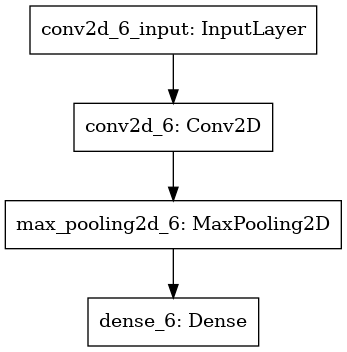

In [69]:
#Bonus round - 
#We can also do fun stuff like this,
#but note you'll need graphviz
#and pydot!  Don't worry if you can't get
#this working - just to give you a visual
#version of your model.
#Note you may need to restart Jupyter
#after you install pydot (if you want to
#debug!)
from keras.utils import plot_model
plot_model(m)